In [1]:

import pandas as pd
import numpy as np
from torchmetrics import MeanSquaredError, MeanAbsoluteError
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss,MAE, RMSE, MAPE, SMAPE
from lightning.pytorch import Trainer
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pytorch_forecasting.models import TimeXer
import pickle
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from lightning.pytorch.callbacks import EarlyStopping


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
df = pd.read_csv("data/timexer.csv", parse_dates=["date"])
df = df.sort_values("date")
df["time_idx"] = (df["date"] - df["date"].min()).dt.total_seconds().astype(int)
df["series_id"] = 0

In [4]:
num_train = int(len(df) * 0.7)
num_test  = int(len(df) * 0.2)
num_vali  = len(df) - num_train - num_test

In [5]:
train_df = df.iloc[:num_train]
val_df   = df.iloc[num_train : num_train + num_vali]
test_df  = df.iloc[num_train + num_vali :]


In [11]:
max_encoder_length    = 50  # look back 50 timesteps
max_prediction_length = 1

In [12]:
time_varying_known_reals=[
        "bytes_op0", "bytes_op1", "bytes_sum", "io_count",
        "read_ops_count", "write_ops_count",
        "bytes_sum_ema_short", "bytes_sum_ema_long",
        "bytes_sum_macd", "bytes_sum_macd_signal",
    ]

In [13]:
covariate_scalers = {
    var: GroupNormalizer(groups=["series_id"]) 
    for var in time_varying_known_reals
}

In [14]:
training = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    group_ids=["series_id"],
    target="duration_sum",
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_reals=[
        "bytes_op0", "bytes_op1", "bytes_sum", "io_count",
        "read_ops_count", "write_ops_count",
        "bytes_sum_ema_short", "bytes_sum_ema_long",
        "bytes_sum_macd", "bytes_sum_macd_signal",
    ],
    time_varying_unknown_reals=["duration_sum"],
    target_normalizer=GroupNormalizer(groups=["series_id"]),
    # scalers will apply GroupNormalizer to each covariate per series
    scalers=covariate_scalers,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [15]:
validation = TimeSeriesDataSet(
    val_df,                              # use your val split
    time_idx="time_idx",
    group_ids=["series_id"],
    target="duration_sum",
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_reals=[
        "bytes_op0","bytes_op1","bytes_sum","io_count",
        "read_ops_count","write_ops_count",
        "bytes_sum_ema_short","bytes_sum_ema_long",
        "bytes_sum_macd","bytes_sum_macd_signal",
    ],
    time_varying_unknown_reals=["duration_sum"],
    target_normalizer=GroupNormalizer(groups=["series_id"]),
    # scalers will apply GroupNormalizer to each covariate per series
    scalers=covariate_scalers,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

test = TimeSeriesDataSet(
    test_df,                            # use your test split
    time_idx="time_idx",
    group_ids=["series_id"],
    target="duration_sum",
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_reals=[
        "bytes_op0","bytes_op1","bytes_sum","io_count",
        "read_ops_count","write_ops_count",
        "bytes_sum_ema_short","bytes_sum_ema_long",
        "bytes_sum_macd","bytes_sum_macd_signal",
    ],
    time_varying_unknown_reals=["duration_sum"],
    target_normalizer=GroupNormalizer(groups=["series_id"]),
    # scalers will apply GroupNormalizer to each covariate per series
    scalers=covariate_scalers,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    
)

In [16]:
batch_size = 64
train_loader = training.to_dataloader(train=True,  batch_size=batch_size, num_workers=0)
val_loader   = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test_loader  = test.to_dataloader(train=False, batch_size=batch_size, num_workers=0)


In [17]:
early_stop = EarlyStopping(
    monitor="val_loss",    # or the metric name you care about
    patience=5,            # stop trial if no improvement for 5 epochs
    mode="min",            # minimize the validation loss
)

In [27]:
# study = optimize_hyperparameters(
#     train_dataloaders         = train_loader,
#     val_dataloaders           = val_loader,
#     model_path               = "optuna_tft",
#     n_trials                 = 50,
#     max_epochs               = 30,
#     gradient_clip_val_range  = (0.01, 1.0),
#     hidden_size_range        = (8, 128),
#     hidden_continuous_size_range = (8, 128),
#     attention_head_size_range   = (1, 4),
#     learning_rate_range         = (1e-4, 1e-1),
#     dropout_range               = (0.1, 0.3),
#     trainer_kwargs              = dict(
#         accelerator="gpu",
#         devices=[0],
#         limit_train_batches=30,
#         callbacks=[early_stop],     # ← include EarlyStopping here
#     ),
#     reduce_on_plateau_patience   = 4,
#     use_learning_rate_finder     = False,
#     loss                         = MeanSquaredError(),
# )


In [28]:
# print("Number of completed trials:", len(study.trials))
# print("Best validation loss:", study.best_value)
# print("Best hyperparameters:")
# for k, v in study.best_trial.params.items():
#     print(f"  • {k}: {v}")


In [13]:
# unpack the batch
x, (target, weight) = next(iter(train_loader))

# inspect your inputs…
print("encoder_cont shape:", x["encoder_cont"].shape)   # [64, 10, 15]
print("decoder_cont shape:", x["decoder_cont"].shape)   # [64,  5, 15]

# …and your targets
print("target shape:", target.shape)                    # [64, 5]

# weight will be None unless you set up sample‐weights
print("sample_weight:", weight)                         # None

    

encoder_cont shape: torch.Size([64, 50, 15])
decoder_cont shape: torch.Size([64, 1, 15])
target shape: torch.Size([64, 1])
sample_weight: None


In [18]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    # learning_rate=0.008657194727953408,
    learning_rate=1e-3,
    hidden_size=128,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=128,
    loss=QuantileLoss(quantiles=[0.1, 0.5, 0.9,0.99,0.999]),  
    output_size=5,              # default: QuantileLoss
    logging_metrics=[SMAPE(),MAE(), RMSE(), MAPE()],
    log_interval=0,
    reduce_on_plateau_patience=4,
)

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.


In [19]:
trainer = Trainer(
    max_epochs=50,
    accelerator="gpu",
    devices=1,
    gradient_clip_val=0.1,
    callbacks=[early_stop]
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [20]:
trainer.fit(tft, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 3.8 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 200 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 819 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 749 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 66.3 K | train
8  | static_context_initial_hidden_lstm |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [21]:
raw_outputs = tft.predict(
    test_loader,
    mode="raw",           # request the full forward() dict
    return_x=False,
    return_y=False,
    batch_size=batch_size,
    num_workers=0
)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


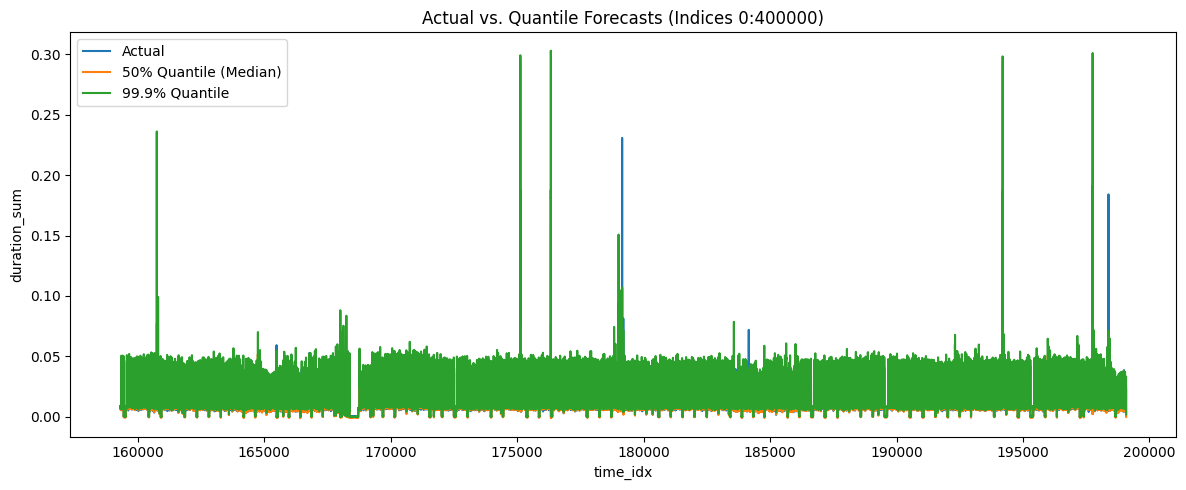

In [57]:
quantiles = raw_outputs.prediction.detach().cpu().numpy()  # (n_windows, 1, 3)
q10, q50, q90,q99,q999 = quantiles[:, 0, 0], quantiles[:, 0, 1], quantiles[:, 0, 2],quantiles[:, 0, 2], quantiles[:, 0, 3]

# 3) Get the true values
actuals = np.concatenate([y.detach().cpu().numpy() for _, (y, _) in iter(test_loader)], axis=0).flatten()

# 4) Build timestamps (for horizon=1)
timestamps = test_df["time_idx"].iloc[max_encoder_length : max_encoder_length + len(actuals)].reset_index(drop=True)
start_idx = 0   # or whatever index you want to start at
end_idx   = 400000   # up to (but not including) this index

# Slice everything
ts_slice     = timestamps.iloc[start_idx:end_idx]
actual_slice = actuals[start_idx:end_idx]
q10_slice    = q10[start_idx:end_idx]
q50_slice    = q50[start_idx:end_idx]
q90_slice    = q90[start_idx:end_idx]
q99_slice    = q99[start_idx:end_idx]
q999_slice   = q999[start_idx:end_idx]

# Plot
plt.figure(figsize=(12, 5))
plt.plot(ts_slice, actual_slice, label="Actual")
# plt.plot(ts_slice, q10_slice,  label="10% Quantile")
plt.plot(ts_slice, q50_slice,  label="50% Quantile (Median)")
# plt.plot(ts_slice, q90_slice,  label="90% Quantile")
# plt.plot(ts_slice, q99_slice,  label="99% Quantile")
plt.plot(ts_slice, q999_slice, label="99.9% Quantile")
plt.xlabel("time_idx")
plt.ylabel("duration_sum")
plt.title(f"Actual vs. Quantile Forecasts (Indices {start_idx}:{end_idx})")
plt.legend()
plt.tight_layout()
plt.show()


In [92]:
# clip negatives to zero
q50  = np.clip(q50,  a_min=0.0, a_max=None)
q999 = np.clip(q999, a_min=0.0, a_max=None)

R      = 2
q999_min = np.percentile(q999, 95)   # only consider tail forecasts in top 5%

# 1) require the tail forecast itself to be large
mask_large_tail = q999 >= q999_min

# 2) among those, require a large ratio
mask_ratio     = q999 > (R * (q50 + 1e-8))

mask = mask_large_tail & mask_ratio
warning_idxs = np.where(mask)[0]

len(warning_idxs)

53

In [93]:
warning_times = timestamps.iloc[warning_idxs]

# And the clipped quantile values
warn_q50  = q50[warning_idxs]
warn_q999 = q999[warning_idxs]

# Print a few examples
for idx, t in zip(warning_idxs[:10], warning_times[:10]):
    print(f"Index {idx}, time {t}: q50={q50[idx]:.8f}, q999={q999[idx]:.8f}")

Index 1436, time 160748: q50=0.07739399, q999=0.23605292
Index 1488, time 160800: q50=0.03997202, q999=0.09926517
Index 8816, time 168128: q50=0.03638459, q999=0.07539986
Index 15810, time 175122: q50=0.03855285, q999=0.09070119
Index 15811, time 175123: q50=0.07495312, q999=0.28662160
Index 15812, time 175124: q50=0.07484391, q999=0.29905930
Index 15813, time 175125: q50=0.07531355, q999=0.29077324
Index 15814, time 175126: q50=0.07574272, q999=0.28781906
Index 15815, time 175127: q50=0.05604132, q999=0.21350284
Index 15816, time 175128: q50=0.07306381, q999=0.29158860


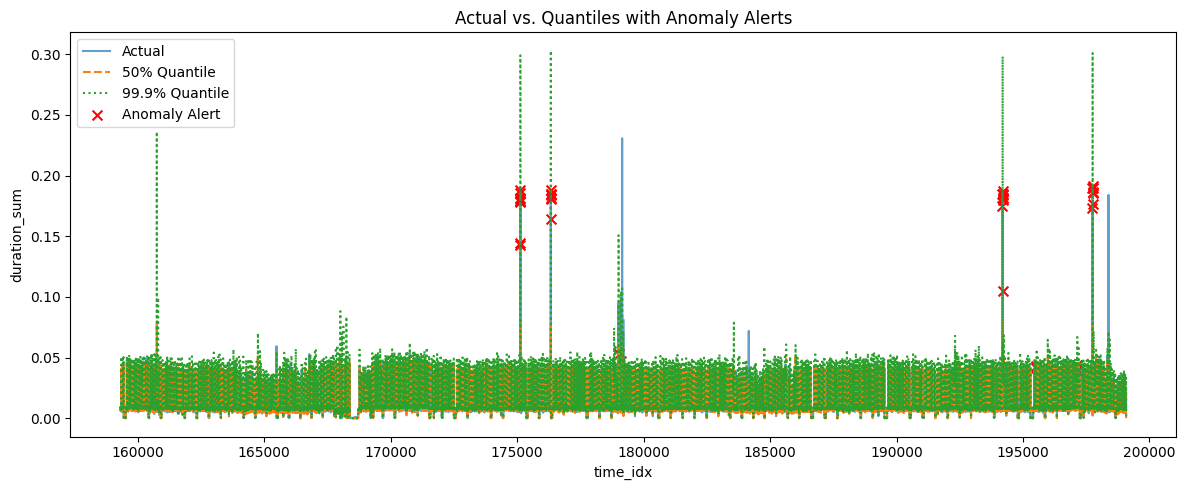

In [94]:
# 2) Prepare plot slices
start_idx = 0
end_idx = min(len(actuals), 400000)

ts_slice     = timestamps.iloc[start_idx:end_idx]
actual_slice = actuals[start_idx:end_idx]
q50_slice    = q50[start_idx:end_idx]
q999_slice   = q999[start_idx:end_idx]

warning_in_slice = warning_idxs[(warning_idxs >= start_idx) & (warning_idxs < end_idx)]
warning_times = timestamps.iloc[warning_in_slice - 1]  # because warning_idxs refers to t

# 3) Plot with markers
plt.figure(figsize=(12, 5))
plt.plot(ts_slice, actual_slice, label="Actual", alpha=0.7)
plt.plot(ts_slice, q50_slice,    label="50% Quantile",   linestyle="--")
plt.plot(ts_slice, q999_slice,   label="99.9% Quantile", linestyle=":")

plt.scatter(warning_times, actuals[warning_in_slice], color="red", marker="x", s=50, label="Anomaly Alert")

plt.xlabel("time_idx")
plt.ylabel("duration_sum")
plt.title("Actual vs. Quantiles with Anomaly Alerts")
plt.legend()
plt.tight_layout()
plt.show()

In [48]:
# assume q50 and q999 are 1-D np.arrays of length N
ratio = q999 / (q50 + 1e-8)     # avoid division by zero

# find the highest ratio
max_idx   = np.argmax(ratio)
max_ratio = ratio[max_idx]
max_q50   = q50[max_idx]
max_q999  = q999[max_idx]

# find the lowest ratio
min_idx   = np.argmin(ratio)
min_ratio = ratio[min_idx]
min_q50   = q50[min_idx]
min_q999  = q999[min_idx]

print(f"Highest ratio at index {max_idx}:")
print(f"  q50   = {max_q50:.4f}")
print(f"  q999  = {max_q999:.4f}")
print(f"  ratio = {max_ratio:.4f}")

print(f"\nLowest ratio at index {min_idx}:")
print(f"  q50   = {min_q50:.4f}")
print(f"  q999  = {min_q999:.4f}")
print(f"  ratio = {min_ratio:.4f}")

Highest ratio at index 38350:
  q50   = 0.0078
  q999  = 0.0078
  ratio = 0.9957

Lowest ratio at index 24585:
  q50   = 0.0008
  q999  = -0.0001
  ratio = -0.1168


In [101]:
# 1) Get raw inputs + outputs
raw = tft.predict(
    test_loader,
    mode="raw",
    )


# 3) Plot each window (or just window 0 if there's only one)
for idx in range(1):
    plt.figure(figsize=(10, 4))
    tft.plot_prediction(
        raw.x,
        raw.output,
        idx=idx,
        add_loss_to_title=True
    )
    plt.show()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


AttributeError: 'Output' object has no attribute 'x'

<Figure size 1000x400 with 0 Axes>

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x500 with 1 Axes>,
 'decoder_variables': <Figure size 700x475 with 1 Axes>}

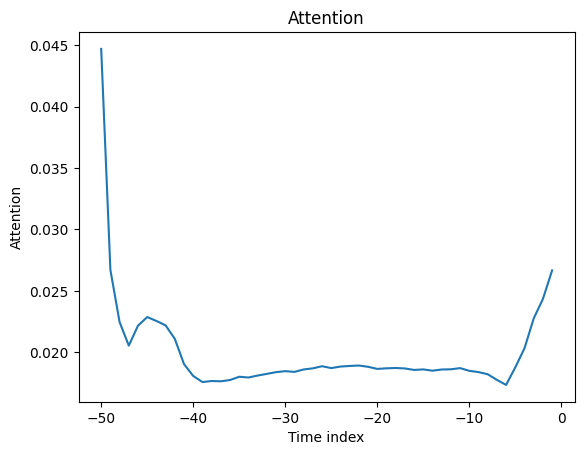

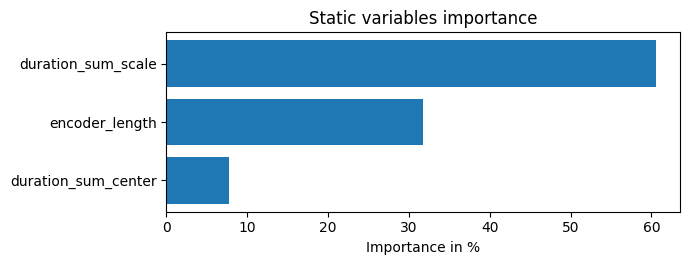

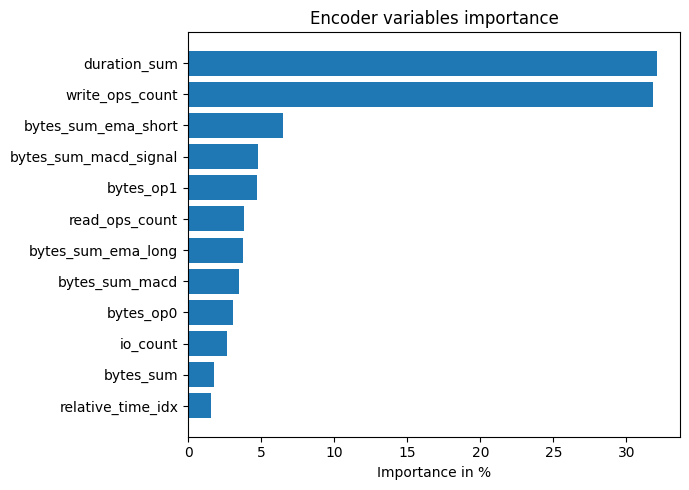

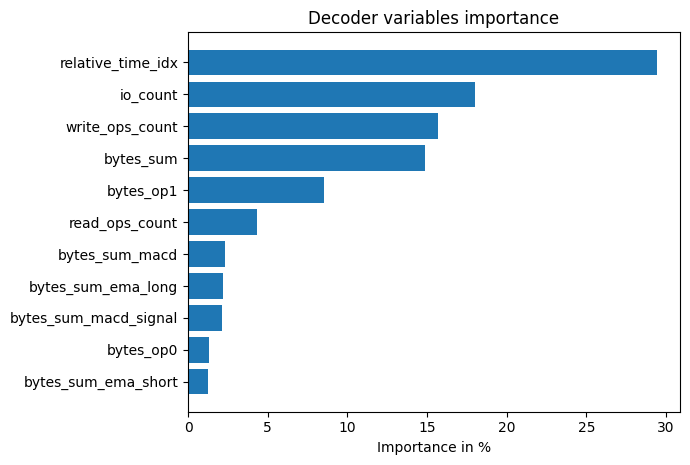

In [102]:
raw_output = tft.predict(
    test_loader,
    mode="raw"         # don't set return_x_y
)
interpretation = tft.interpret_output(raw_output, reduction="sum")
tft.plot_interpretation(interpretation)

In [30]:
timexer = TimeXer.from_dataset(
    training,
    # you don't need to re‐pass context_length/prediction_length:
    # from_dataset will pick them up from `training`
    # just override the Transformer hyperparams:
    hidden_size       = 256,
    n_heads           = 4,
    e_layers          = 2,
    d_ff              = 1024,
    dropout           = 0.2,
    activation        = "relu",
    patch_length      = 5,              # must be <= 10
    factor            = 5,
    embed_type        = "fixed",
    freq              = "s",            # since your time_idx is in seconds
    loss              = MeanSquaredError(),
    learning_rate     = 1e-3,
)

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [31]:
trainer = Trainer(
    max_epochs        = 20,
    accelerator       = "gpu",
    # devices           = [1],            # using GPU 1
    gradient_clip_val = 0.1,
)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [32]:

trainer.fit(timexer, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                   | Params | Mode 
-------------------------------------------------------------------
0 | loss            | TorchMetricWrapper     | 0      | train
1 | logging_metrics | ModuleList             | 0      | train
2 | en_embedding    | EnEmbedding            | 1.5 K  | train
3 | ex_embedding    | DataEmbedding_inverted | 13.1 K | train
4 | encoder         | Encoder                | 2.1 M  | train
5 | head            | FlattenHead            | 56.3 K | train
-------------------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.713     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [33]:
# 1) Get raw NumPy forecasts from TimeXer
preds_raw = timexer.predict(test_loader)

# 2) Ensure preds is a NumPy array on the CPU
if isinstance(preds_raw, torch.Tensor):
    preds = preds_raw.detach().cpu().numpy()
else:
    preds = preds_raw

# 3) Gather true targets, forcing CPU→NumPy
actuals = np.concatenate(
    [y.detach().cpu().numpy() for _, (y, _) in iter(test_loader)],
    axis=0
)

# 4) Compute MSE over all windows & steps
mse = mean_squared_error(actuals.flatten(), preds.flatten())
print(f"TimeXer Test MSE: {mse:.6f}")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


TimeXer Test MSE: 0.000046


In [ ]:
# 5) Get raw inputs + outputs for plotting
raw = timexer.predict(
    test_loader,
    mode="raw",
    return_x=True
)

# 6) How many windows?
n_windows = raw.output["prediction"].shape[0]
print(f"Number of test windows = {n_windows}")

# 7) Plot up to 10 windows (or fewer if n_windows < 10)
for idx in range(min(10, n_windows)):
    plt.figure(figsize=(10, 4))
    timexer.plot_prediction(
        raw.x,
        raw.output,
        idx=idx,
        add_loss_to_title=True
    )
    plt.show()